In [1]:
import sys, os
import torch
import torch.nn as nn
sys.path.append("/home/username/open_clip_original/")
sys.path.insert(0,"/home/username/open_clip_original/src/")
from open_clip import create_model_and_transforms, trace_model, get_tokenizer, create_loss
from training.data import get_data
from training.data import get_data_transformer
from training.distributed import is_master, init_distributed_device, broadcast_object
from training.params import parse_args
from open_clip.transformer import HeadTransformer
import json
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import numpy as np

class MyCosineLoss(nn.Module):

    def __init__(self,reduction='none'):
        super().__init__()
        self.reduction=reduction
        # self._backward_hooks = None
        # self._backward_pre_hooks = None

    def forward(self,x:torch.Tensor,y:torch.Tensor,target:torch.Tensor):
        x_norm = x.norm(2,dim=1)
        y_norm = y.norm(2,dim=1)
        cos = (x * y).sum(dim=-1)
        losses = 1 - cos/x_norm/y_norm
        if self.reduction == 'none':
            return losses
        elif self.reduction == 'mean':
            return losses.mean()

def create_head_transformer(arhitecture=None):
    # loss=torch.nn.CosineEmbeddingLoss(reduction='none')
    loss=MyCosineLoss(reduction='none')
    head=HeadTransformer(layers=arhitecture)
    return head,loss



In [ ]:
sys.path

In [2]:
all_classes = {}
all_data = {}
for ds in ['britmus','vamus']:
    ds_data = []
    classes_path = f"/home/username/open_clip/finetuning/dataset_splits/{ds}_classes.json"
    with open(classes_path) as f:
        all_classes[ds] = json.load(f)
    for tp in ['train','test','val']:
        part_data = pd.read_csv(f"/home/username/open_clip/finetuning/dataset_splits/{ds}_{tp}.csv",sep=',')
        print(ds,tp,part_data.shape)
        ds_data.append(part_data)

    all_data[ds] = pd.concat(ds_data)
    print(ds,all_data[ds].shape,len(all_classes[ds]))

britmus train (69369, 17)
britmus test (12808, 17)
britmus val (6404, 17)
britmus (88581, 17) 16
vamus train (108320, 21)
vamus test (20000, 21)
vamus val (10000, 21)
vamus (138320, 21) 18


In [3]:
all_classes['britmus'].keys()

dict_keys(['image_path', 'caption', 'Museum number', 'Subjects', 'Curators Comments', 'Inscription', 'Technique', 'Materials', 'Production place', 'Production date', 'Assoc name', 'Culture', 'Object type', 'Producer name', 'School/style', 'Title'])

### VAMUS

In [4]:
all_class_info = {}

In [5]:
dataset = 'vamus'
at_names = []
num_classes = []
avg_len = []
classnames = all_classes[dataset] 
for k,v in all_classes[dataset].items():
    at_names.append(k)
    num_classes.append(len(v))
    avg_len.append(sum([len(tx) for tx in v.values()])/len(v))
    # print(k,len(v),sum([len(tx) for tx in v.values()])/len(v))

class_info = pd.DataFrame({
    "attribute":at_names,
    "different_values":num_classes,
    "avg_len_of_values":avg_len
})
class_info.sort_values('different_values',ascending=True)

,attribute,different_values,avg_len_of_values
12,productionDates,266,10.661654
8,categories,573,7.506108
9,styles,655,7.087023
6,techniques,999,8.260260
5,materials,1199,7.065888
11,placesOfOrigin,4198,9.729395
10,partTypes,5006,6.938873
0,objectType,7281,13.126631
4,artistMakerPerson,16758,9.909118
17,production,18930,53.607554


In [6]:
num_values = {k:0 for k in classnames}
num_known_values = {k:0 for k in classnames}
num_unknowns = {k:0 for k in classnames}
num_known = {k:0 for k in classnames}
num_single = {k:0 for k in classnames}
num_uniques = {k:set() for k in classnames}
num_tot_len = {k:0 for k in classnames}
tot_lens = {k:[] for k in classnames}
num_max_len = {k:0 for k in classnames}
num_min_len = {k:1e6 for k in classnames}
unknown_freq = [0 for k in range(len(classnames)+1)]
num_known_attr = []
attr_length = {k:[] for k in classnames}
total_num = 0
for idx, row in tqdm(all_data[dataset].iterrows()):
    # print(len(attributes))
    img_name = row['image_path'].split('/')[-1]
    current_unks = 0
    current_known = 0
    for k in class_info['attribute']:
        # print('',k,att[k])
        att = json.loads(row[k])
        if len(att) == 0 or classnames[k][str(att[0])] == 'unknown' or classnames[k][str(att[0])].strip() == 'nan' or classnames[k][str(att[0])].strip() in '.,:;' :
            num_unknowns[k] += 1
            current_unks += 1
        else:
            num_known[k] += 1
            current_known += 1
            num_known_values[k] += len(att)
            current_tot_len = sum([len(classnames[k][str(at)]) for at in att])
            num_tot_len[k] += current_tot_len
            attr_length[k].append((current_tot_len,img_name))
            tot_lens[k].append(current_tot_len)
            if current_tot_len > num_max_len[k]:
                num_max_len[k] = current_tot_len
            if current_tot_len < num_min_len[k]:
                num_min_len[k] = current_tot_len
                # print(f'new min for {k}:',", ".join([(classnames[k][str(at)]) for at in att]))
        if len(att) == 1:
            num_single[k] += 1
        num_values[k] += len(att)
        num_uniques[k].update(att)
    total_num += 1
    unknown_freq[current_unks] += 1
    num_known_attr.append((current_known,img_name))

print(total_num)
print(num_unknowns)    
print(num_values)    
print(unknown_freq)


138320it [00:20, 6828.38it/s]

138320
{'objectType': 10, 'titles': 84678, 'summaryDescription': 97889, 'physicalDescription': 23261, 'artistMakerPerson': 81951, 'materials': 45715, 'techniques': 55323, 'materialsAndTechniques': 20769, 'categories': 16324, 'styles': 108778, 'partTypes': 1, 'placesOfOrigin': 17595, 'productionDates': 9878, 'marksAndInscriptions': 101617, 'objectHistory': 82577, 'historicalContext': 130880, 'briefDescription': 1662, 'production': 118641}
{'objectType': 138539, 'titles': 158410, 'summaryDescription': 435643, 'physicalDescription': 374850, 'artistMakerPerson': 191790, 'materials': 254492, 'techniques': 206463, 'materialsAndTechniques': 186677, 'categories': 411606, 'styles': 158544, 'partTypes': 207468, 'placesOfOrigin': 147750, 'productionDates': 139819, 'marksAndInscriptions': 156684, 'objectHistory': 1000026, 'historicalContext': 196292, 'briefDescription': 541710, 'production': 154779}
[27, 249, 1669, 5739, 11808, 20236, 25462, 21039, 14911, 12453, 8190, 3164, 2264, 4431, 4851, 1698,

In [7]:
for k in attr_length:
    attr_length[k].sort()
num_known_attr.sort()

In [8]:
attr_length_v = attr_length

In [86]:
print('By number of known attributes')
print(num_known_attr[:10])
print(num_known_attr[-10:][::-1])
print('By length of summaryDescription')
print(attr_length['summaryDescription'][:10])
print(attr_length['summaryDescription'][-10:][::-1])
print('By length of physicalDescription')
print(attr_length['physicalDescription'][:10])
print(attr_length['physicalDescription'][-10:][::-1])
print('By length of objectHistory')
print(attr_length['objectHistory'][:10])
print(attr_length['objectHistory'][-10:][::-1])

By number of known attributes
[(2, 'O106945.jpg'), (2, 'O106957.jpg'), (2, 'O106962.jpg'), (2, 'O107887.jpg'), (2, 'O114660.jpg'), (2, 'O1160161.jpg'), (2, 'O1171244.jpg'), (2, 'O1190487.jpg'), (2, 'O119329.jpg'), (2, 'O166398.jpg')]
[(18, 'O922664.jpg'), (18, 'O922663.jpg'), (18, 'O922662.jpg'), (18, 'O922661.jpg'), (18, 'O922660.jpg'), (18, 'O83283.jpg'), (18, 'O80599.jpg'), (18, 'O7755.jpg'), (18, 'O74439.jpg'), (18, 'O70986.jpg')]
By length of summaryDescription
[(14, 'O33631.jpg'), (17, 'O176688.jpg'), (19, 'O1418173.jpg'), (23, 'O176740.jpg'), (23, 'O185144.jpg'), (23, 'O186409.jpg'), (24, 'O113389.jpg'), (24, 'O113394.jpg'), (24, 'O176630.jpg'), (24, 'O176634.jpg')]
[(15476, 'O1359652.jpg'), (15110, 'O1359654.jpg'), (14996, 'O1359653.jpg'), (14920, 'O1348659.jpg'), (12110, 'O1597616.jpg'), (6777, 'O1194570.jpg'), (6773, 'O1194571.jpg'), (6763, 'O1194574.jpg'), (6447, 'O1249536.jpg'), (6308, 'O18900.jpg')]
By length of physicalDescription
[(3, 'O87178.jpg'), (3, 'O87192.jpg'), (3

In [9]:
class_info['num_unknown'] = [num_unknowns[k] for k in class_info['attribute']]
class_info['num_known'] = [num_known[k] for k in class_info['attribute']]
class_info['num_single'] = [num_single[k] for k in class_info['attribute']]
class_info['num_uniques_in_val'] = [len(num_uniques[k]) for k in class_info['attribute']]
class_info['avg_num_values'] = [num_values[k] / total_num for k in class_info['attribute']]
class_info['avg_num_known_values'] = [num_known_values[k] / num_known[k] for k in class_info['attribute']]
class_info['avg_known_len'] = [num_tot_len[k] / num_known[k] for k in class_info['attribute']]
class_info['max_known_len'] = [num_max_len[k] for k in class_info['attribute']]
class_info['min_known_len'] = [num_min_len[k] for k in class_info['attribute']]
class_info['med_known_len'] = [np.median(tot_lens[k]) for k in class_info['attribute']]
class_info.sort_values('different_values',ascending=True)

,attribute,different_values,avg_len_of_values,num_unknown,num_known,num_single,num_uniques_in_val,avg_num_values,avg_num_known_values,avg_known_len,max_known_len,min_known_len,med_known_len
12,productionDates,266,10.661654,9878,128442,136479,266,1.010837,1.012800,6.851645,32,5,6.0
8,categories,573,7.506108,16324,121996,37525,573,2.975752,3.240123,25.847888,150,3,21.0
9,styles,655,7.087023,108778,29542,124342,655,1.146212,1.684585,11.595254,53,3,11.0
6,techniques,999,8.260260,55323,82997,92708,999,1.492647,1.822018,14.047460,83,3,13.0
5,materials,1199,7.065888,45715,92605,75835,1196,1.839879,2.255256,14.178954,117,3,14.0
11,placesOfOrigin,4198,9.729395,17595,120725,129432,4196,1.068175,1.078517,8.121226,112,2,7.0
10,partTypes,5006,6.938873,1,138319,89616,5004,1.499913,1.499924,9.801285,624,2,8.0
0,objectType,7281,13.126631,10,138310,138115,7279,1.001583,1.001583,9.018133,45,2,8.0
4,artistMakerPerson,16758,9.909118,81951,56369,96458,16757,1.386567,1.950150,17.093207,360,2,15.0
17,production,18930,53.607554,118641,19679,131896,18922,1.118992,1.835967,83.377509,3255,1,40.0


In [10]:
all_class_info[dataset] = class_info

In [10]:
classif_keys_v = classif_keys = class_info['attribute'][class_info['different_values'] < 10000].to_list()
predict_keys_v = predict_keys = class_info['attribute'][class_info['different_values'] > 10000].to_list()
print('cls',classif_keys)
print('prd',predict_keys)

cls ['objectType', 'materials', 'techniques', 'categories', 'styles', 'partTypes', 'placesOfOrigin', 'productionDates']
prd ['titles', 'summaryDescription', 'physicalDescription', 'artistMakerPerson', 'materialsAndTechniques', 'marksAndInscriptions', 'objectHistory', 'historicalContext', 'briefDescription', 'production']


In [12]:
for key in predict_keys_v:
    print(f'By length of {key}')
    print(attr_length[key][:10])
    print(attr_length[key][-10:][::-1])
    print()

By length of titles
[(1, 'O161653.jpg'), (1, 'O161658.jpg'), (1, 'O239511.jpg'), (2, 'O1137711.jpg'), (2, 'O1194565.jpg'), (2, 'O1332945.jpg'), (2, 'O163547.jpg'), (2, 'O168605.jpg'), (2, 'O168666.jpg'), (2, 'O168674.jpg')]
[(429, 'O1503042.jpg'), (428, 'O1503053.jpg'), (421, 'O755370.jpg'), (399, 'O553985.jpg'), (399, 'O553980.jpg'), (388, 'O1403332.jpg'), (355, 'O854707.jpg'), (354, 'O854666.jpg'), (354, 'O854665.jpg'), (354, 'O854661.jpg')]

By length of summaryDescription
[(14, 'O33631.jpg'), (17, 'O176688.jpg'), (19, 'O1418173.jpg'), (23, 'O176740.jpg'), (23, 'O185144.jpg'), (23, 'O186409.jpg'), (24, 'O113389.jpg'), (24, 'O113394.jpg'), (24, 'O176630.jpg'), (24, 'O176634.jpg')]
[(15476, 'O1359652.jpg'), (15110, 'O1359654.jpg'), (14996, 'O1359653.jpg'), (14920, 'O1348659.jpg'), (12110, 'O1597616.jpg'), (6777, 'O1194570.jpg'), (6773, 'O1194571.jpg'), (6763, 'O1194574.jpg'), (6447, 'O1249536.jpg'), (6308, 'O18900.jpg')]

By length of physicalDescription
[(3, 'O87178.jpg'), (3, 'O8719

<Axes: xlabel='attribute'>

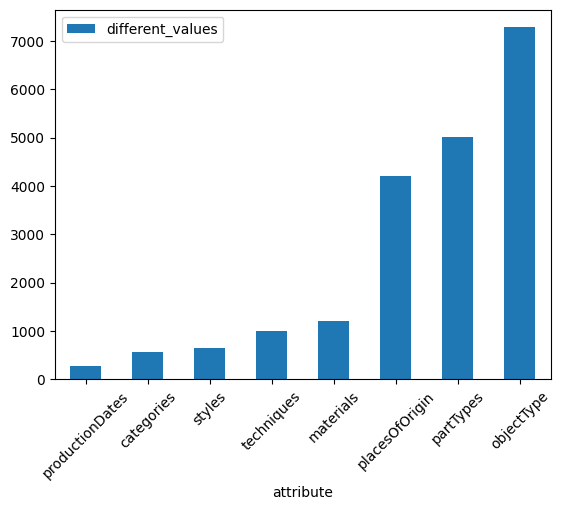

In [12]:
class_info_classif = class_info[class_info['different_values'] < 10000]
ax = class_info_classif.sort_values('different_values',ascending=True).plot.bar(x='attribute',y='different_values',rot=45)
ax

<Axes: xlabel='attribute'>

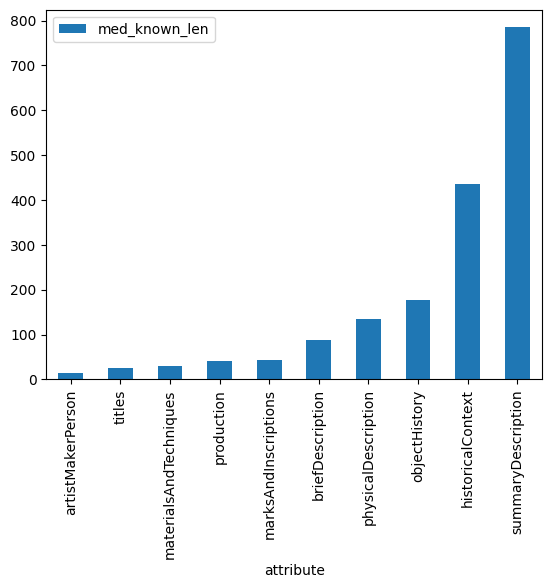

In [13]:
class_info_predict = class_info[class_info['different_values'] > 10000]
ax = class_info_predict.sort_values('med_known_len',ascending=True).plot.bar(x='attribute',y='med_known_len',rot=90)
ax

### BRITMUS

In [13]:
dataset = 'britmus'
at_names = []
num_classes = []
avg_len = []
classnames = all_classes[dataset] 
for k,v in all_classes[dataset].items():
    if k in ['School/style','Museum number','caption','image_path']: continue
    at_names.append(k)
    num_classes.append(len(v))
    avg_len.append(sum([len(tx) for tx in v.values()])/len(v))
    # print(k,len(v),sum([len(tx) for tx in v.values()])/len(v))

class_info = pd.DataFrame({
    "attribute":at_names,
    "different_values":num_classes,
    "avg_len_of_values":avg_len
})
class_info.sort_values('different_values',ascending=True)

,attribute,different_values,avg_len_of_values
8,Culture,498,7.094378
4,Materials,561,6.365419
6,Production date,764,9.187173
3,Technique,824,7.260922
0,Subjects,1330,8.030827
9,Object type,2600,8.708462
5,Production place,5615,35.584328
11,Title,6457,46.186929
10,Producer name,10643,49.062107
7,Assoc name,19451,63.792299


In [14]:
num_values = {k:0 for k in classnames}
num_known_values = {k:0 for k in classnames}
num_unknowns = {k:0 for k in classnames}
num_known = {k:0 for k in classnames}
num_single = {k:0 for k in classnames}
num_uniques = {k:set() for k in classnames}
num_tot_len = {k:0 for k in classnames}
tot_lens = {k:[] for k in classnames}
num_max_len = {k:0 for k in classnames}
num_min_len = {k:1e6 for k in classnames}
unknown_freq = [0 for k in range(len(classnames)+1)]
num_known_attr = []
attr_length = {k:[] for k in classnames}
total_num = 0
for idx, row in tqdm(all_data[dataset].iterrows()):
    # print(len(attributes))
    img_name = row['image_path'].split('/')[-1]
    current_unks = 0
    current_known = 0
    for k in class_info['attribute']:
        # print('',k,att[k])
        att = json.loads(row[k])
        if len(att) == 0 or classnames[k][str(att[0])] == 'unknown' or classnames[k][str(att[0])].strip() == 'nan' or classnames[k][str(att[0])].strip() in '.,:;' :
            num_unknowns[k] += 1
            current_unks += 1
        else:
            num_known[k] += 1
            current_known += 1
            num_known_values[k] += len(att)
            current_tot_len = sum([len(classnames[k][str(at)]) for at in att])
            num_tot_len[k] += current_tot_len
            attr_length[k].append((current_tot_len,img_name))
            tot_lens[k].append(current_tot_len)
            if current_tot_len > num_max_len[k]:
                num_max_len[k] = current_tot_len
            if current_tot_len < num_min_len[k]:
                num_min_len[k] = current_tot_len
                # print(f'new min for {k}:',", ".join([(classnames[k][str(at)]) for at in att]))
        if len(att) == 1:
            num_single[k] += 1
        num_values[k] += len(att)
        num_uniques[k].update(att)
    total_num += 1
    unknown_freq[current_unks] += 1
    num_known_attr.append((current_known,img_name))

print(total_num)
print(num_unknowns)    
print(num_values)    
print(unknown_freq)


88581it [00:10, 8824.77it/s]

88581
{'image_path': 0, 'caption': 0, 'Museum number': 0, 'Subjects': 42697, 'Curators Comments': 36447, 'Inscription': 42821, 'Technique': 22816, 'Materials': 598, 'Production place': 31354, 'Production date': 13749, 'Assoc name': 55615, 'Culture': 36005, 'Object type': 7, 'Producer name': 63427, 'School/style': 0, 'Title': 80510}
{'image_path': 0, 'caption': 0, 'Museum number': 0, 'Subjects': 154621, 'Curators Comments': 626243, 'Inscription': 127200, 'Technique': 136738, 'Materials': 119972, 'Production place': 89173, 'Production date': 88894, 'Assoc name': 99135, 'Culture': 136720, 'Object type': 122495, 'Producer name': 89462, 'School/style': 0, 'Title': 90281}
[17, 1010, 4631, 11319, 21248, 21862, 16318, 8494, 3035, 601, 46, 0, 0, 0, 0, 0, 0]


In [15]:
for k in attr_length:
    attr_length[k].sort()
num_known_attr.sort()

In [16]:
attr_length_b = attr_length

In [90]:
attr_length.keys()

dict_keys(['image_path', 'caption', 'Museum number', 'Subjects', 'Curators Comments', 'Inscription', 'Technique', 'Materials', 'Production place', 'Production date', 'Assoc name', 'Culture', 'Object type', 'Producer name', 'School/style', 'Title'])

In [92]:
print('By number of known attributes')
print(num_known_attr[:10])
print(num_known_attr[-10:][::-1])
print('By length of Inscription')
print(attr_length['Inscription'][:10])
print(attr_length['Inscription'][-10:][::-1])
print('By length of Curators Comments')
print(attr_length['Curators Comments'][:10])
print(attr_length['Curators Comments'][-10:][::-1])
print('By length of Assoc name')
print(attr_length['Assoc name'][:10])
print(attr_length['Assoc name'][-10:][::-1])
print()

By number of known attributes
[(2, '000478_Oc1983-13-40.jpg'), (2, '000591_Am-+-7819.jpg'), (2, '000628_Oc1983-13-39-a-h.jpg'), (2, '001844_2022-3034-240.jpg'), (2, '001963_Oc-6461.jpg'), (2, '002113_Oc1886-1015-63.jpg'), (2, '002424_1886-0515-12.jpg'), (2, '003219_As1960-10-92.jpg'), (2, '003493_1882-1010-2.jpg'), (2, '004183_1882-1010-5-11.jpg')]
[(12, '029320_1989-0808-0-1.jpg'), (12, '026763_1836-0224-127.jpg'), (12, '023981_1994-0102-6.jpg'), (12, '014413_1902-0606-0-24.jpg'), (12, '014357_2012-3012-1.jpg'), (12, '014212_1948-1211-0-19.jpg'), (12, '013984_1975-0303-0-3.jpg'), (12, '013961_1965-1011-0-1.jpg'), (12, '013873_1972-0918-0-4.jpg'), (12, '011307_1873-0208-3.jpg')]
By length of Inscription
[(22, '000106_1939-1010-297.jpg'), (22, '011028_1908-0217-1.jpg'), (22, '011038_EA23768.jpg'), (26, '004746_1868-0405-161.jpg'), (26, '010251_AF-2878.jpg'), (26, '010786_1987-0402-8.jpg'), (26, '012754_1978-1002-107.jpg'), (26, '015878_1980-1008-9.jpg'), (26, '017903_1856-1223-411-+.jpg

In [79]:
print(num_known_attr[:10])
print(num_known_attr[-10:])

[(2, '000478_Oc1983-13-40.jpg'), (2, '000591_Am-+-7819.jpg'), (2, '000628_Oc1983-13-39-a-h.jpg'), (2, '001844_2022-3034-240.jpg'), (2, '001963_Oc-6461.jpg'), (2, '002113_Oc1886-1015-63.jpg'), (2, '002424_1886-0515-12.jpg'), (2, '003219_As1960-10-92.jpg'), (2, '003493_1882-1010-2.jpg'), (2, '004183_1882-1010-5-11.jpg')]
[(12, '011307_1873-0208-3.jpg'), (12, '013873_1972-0918-0-4.jpg'), (12, '013961_1965-1011-0-1.jpg'), (12, '013984_1975-0303-0-3.jpg'), (12, '014212_1948-1211-0-19.jpg'), (12, '014357_2012-3012-1.jpg'), (12, '014413_1902-0606-0-24.jpg'), (12, '023981_1994-0102-6.jpg'), (12, '026763_1836-0224-127.jpg'), (12, '029320_1989-0808-0-1.jpg')]


In [78]:
print(attr_length['Inscription'][:10])
print(attr_length['Inscription'][-10:])

[(22, '000106_1939-1010-297.jpg'), (22, '011028_1908-0217-1.jpg'), (22, '011038_EA23768.jpg'), (26, '004746_1868-0405-161.jpg'), (26, '010251_AF-2878.jpg'), (26, '010786_1987-0402-8.jpg'), (26, '012754_1978-1002-107.jpg'), (26, '015878_1980-1008-9.jpg'), (26, '017903_1856-1223-411-+.jpg'), (26, '018647_1987-0401-1.jpg')]
[(6540, '034122_1888-0526-1.jpg'), (6860, '021381_1864-1007-54.jpg'), (7214, '013896_1964-0411-0-1.jpg'), (7248, '047243_1946-0206-1.jpg'), (7349, '047242_1805-0703-232.jpg'), (8143, '001608_OA-2433.jpg'), (8246, '011260_91715.jpg'), (8481, '022144_1877-0815-1.jpg'), (17351, '022990_91000.jpg'), (56565, '013008_121005.jpg')]


In [81]:
print(attr_length['Curators Comments'][:10])
print(attr_length['Curators Comments'][-10:])

[(4, '005143_1994-0915-201.jpg'), (4, '009141_1994-0915-98.jpg'), (6, '023978_1866-0415-31.jpg'), (7, '000443_EPH-ME-1577.jpg'), (7, '004421_1869-0703-1.jpg'), (7, '008478_EPH-ME-1579.jpg'), (7, '009328_1851-1203-7.jpg'), (7, '010691_EPH-ME-1586.jpg'), (7, '013608_TC-p155-16-Ami.jpg'), (7, '015660_1858-0324-20.jpg')]
[(37817, '011799_WB-91.jpg'), (43084, '016592_WB-167.jpg'), (44200, '014830_1856-0718-1.jpg'), (45621, '015324_WB-89.jpg'), (46074, '008574_WB-114.jpg'), (46151, '011114_WB-90.jpg'), (52299, '011080_1884-0606-3.jpg'), (61846, '019887_WB-67.jpg'), (63945, '001781_1888-1201-100.jpg'), (88707, '000673_Eu1983-01-1.jpg')]


In [17]:
class_info['num_unknown'] = [num_unknowns[k] for k in class_info['attribute']]
class_info['num_known'] = [num_known[k] for k in class_info['attribute']]
class_info['num_single'] = [num_single[k] for k in class_info['attribute']]
class_info['num_uniques_in_val'] = [len(num_uniques[k]) for k in class_info['attribute']]
class_info['avg_num_values'] = [num_values[k] / total_num for k in class_info['attribute']]
class_info['avg_num_known_values'] = [num_known_values[k] / num_known[k] for k in class_info['attribute']]
class_info['avg_known_len'] = [num_tot_len[k] / num_known[k] for k in class_info['attribute']]
class_info['max_known_len'] = [num_max_len[k] for k in class_info['attribute']]
class_info['min_known_len'] = [num_min_len[k] for k in class_info['attribute']]
class_info['med_known_len'] = [np.median(tot_lens[k]) for k in class_info['attribute']]
class_info.sort_values('different_values',ascending=True)

,attribute,different_values,avg_len_of_values,num_unknown,num_known,num_single,num_uniques_in_val,avg_num_values,avg_num_known_values,avg_known_len,max_known_len,min_known_len,med_known_len
8,Culture,498,7.094378,36005,52576,56505,498,1.543446,1.915608,12.300822,79,3,12.0
4,Materials,561,6.365419,598,87983,67862,561,1.354376,1.356785,8.013514,118,3,7.0
6,Production date,764,9.187173,13749,74832,88274,760,1.003533,1.002967,7.697549,39,2,6.0
3,Technique,824,7.260922,22816,65765,58619,824,1.543649,1.732259,12.477777,172,3,9.0
0,Subjects,1330,8.030827,42697,45884,58272,1328,1.745532,2.439282,19.792172,428,2,15.0
9,Object type,2600,8.708462,7,88574,61866,2600,1.382859,1.382889,9.322397,208,2,7.0
5,Production place,5615,35.584328,31354,57227,88077,5603,1.006683,1.010345,25.230957,388,12,20.0
11,Title,6457,46.186929,80510,8071,87399,6454,1.019191,1.210631,50.482220,816,9,40.0
10,Producer name,10643,49.062107,63427,25154,88130,10642,1.009946,1.035024,43.713087,3593,10,32.0
7,Assoc name,19451,63.792299,55615,32966,81958,19420,1.119145,1.320148,68.884821,6931,14,50.0


In [17]:
all_class_info[dataset] = class_info

In [18]:
classif_keys_b = classif_keys = class_info['attribute'][class_info['different_values'] < 5000].to_list()
predict_keys_b = predict_keys = class_info['attribute'][class_info['different_values'] > 5000].to_list()
print('cls',classif_keys)
print('prd',predict_keys)

cls ['Subjects', 'Technique', 'Materials', 'Production date', 'Culture', 'Object type']
prd ['Curators Comments', 'Inscription', 'Production place', 'Assoc name', 'Producer name', 'Title']


In [19]:
for key in predict_keys_b:
    print(f'By length of {key}')
    print(attr_length[key][:10])
    print(attr_length[key][-10:][::-1])
    print()

By length of Curators Comments
[(4, '005143_1994-0915-201.jpg'), (4, '009141_1994-0915-98.jpg'), (6, '023978_1866-0415-31.jpg'), (7, '000443_EPH-ME-1577.jpg'), (7, '004421_1869-0703-1.jpg'), (7, '008478_EPH-ME-1579.jpg'), (7, '009328_1851-1203-7.jpg'), (7, '010691_EPH-ME-1586.jpg'), (7, '013608_TC-p155-16-Ami.jpg'), (7, '015660_1858-0324-20.jpg')]
[(88707, '000673_Eu1983-01-1.jpg'), (63945, '001781_1888-1201-100.jpg'), (61846, '019887_WB-67.jpg'), (52299, '011080_1884-0606-3.jpg'), (46151, '011114_WB-90.jpg'), (46074, '008574_WB-114.jpg'), (45621, '015324_WB-89.jpg'), (44200, '014830_1856-0718-1.jpg'), (43084, '016592_WB-167.jpg'), (37817, '011799_WB-91.jpg')]

By length of Inscription
[(22, '000106_1939-1010-297.jpg'), (22, '011028_1908-0217-1.jpg'), (22, '011038_EA23768.jpg'), (26, '004746_1868-0405-161.jpg'), (26, '010251_AF-2878.jpg'), (26, '010786_1987-0402-8.jpg'), (26, '012754_1978-1002-107.jpg'), (26, '015878_1980-1008-9.jpg'), (26, '017903_1856-1223-411-+.jpg'), (26, '018647_1

<Axes: xlabel='attribute'>

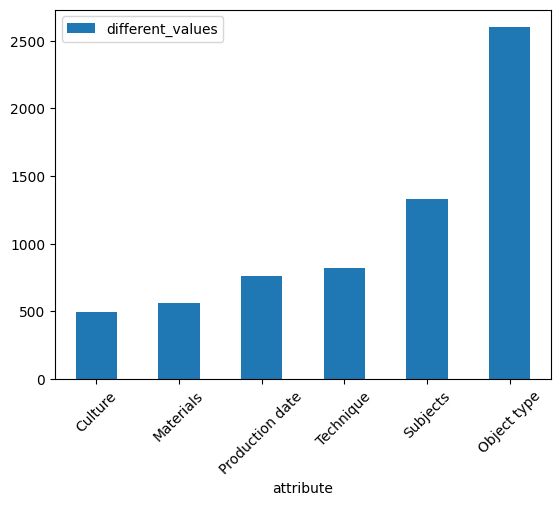

In [19]:
class_info_classif = class_info[class_info['different_values'] < 5000]
ax = class_info_classif.sort_values('different_values',ascending=True).plot.bar(x='attribute',y='different_values',rot=45)
ax

<Axes: xlabel='attribute'>

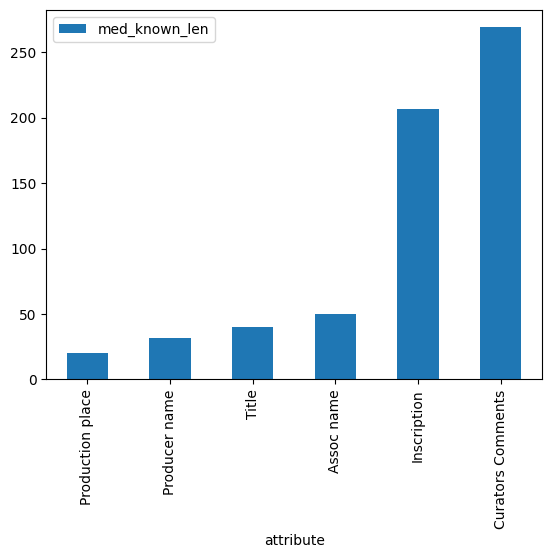

In [20]:
class_info_predict = class_info[class_info['different_values'] > 5000]
ax = class_info_predict.sort_values('med_known_len',ascending=True).plot.bar(x='attribute',y='med_known_len',rot=90)
ax

In [96]:
for kk in predict_keys:
    print(kk,len(attr_length[kk]),attr_length[kk][-1])

Curators Comments 52134 (88707, '000673_Eu1983-01-1.jpg')
Inscription 45760 (56565, '013008_121005.jpg')
Production place 57227 (388, '014127_1856-0710-46.jpg')
Assoc name 32966 (6931, '019785_1868-0808-3355-1-4.jpg')
Producer name 25154 (3593, '018815_1913-0415-179.jpg')
Title 8071 (816, '011898_1868-0808-12290.jpg')


In [154]:
attr_lengths_b = {k:[v[0] for v in vals] for k,vals in attr_length_b.items()}
attr_lengths_v = {k:[v[0] for v in vals] for k,vals in attr_length_v.items()}

In [160]:
import matplotlib.patches as mpatches

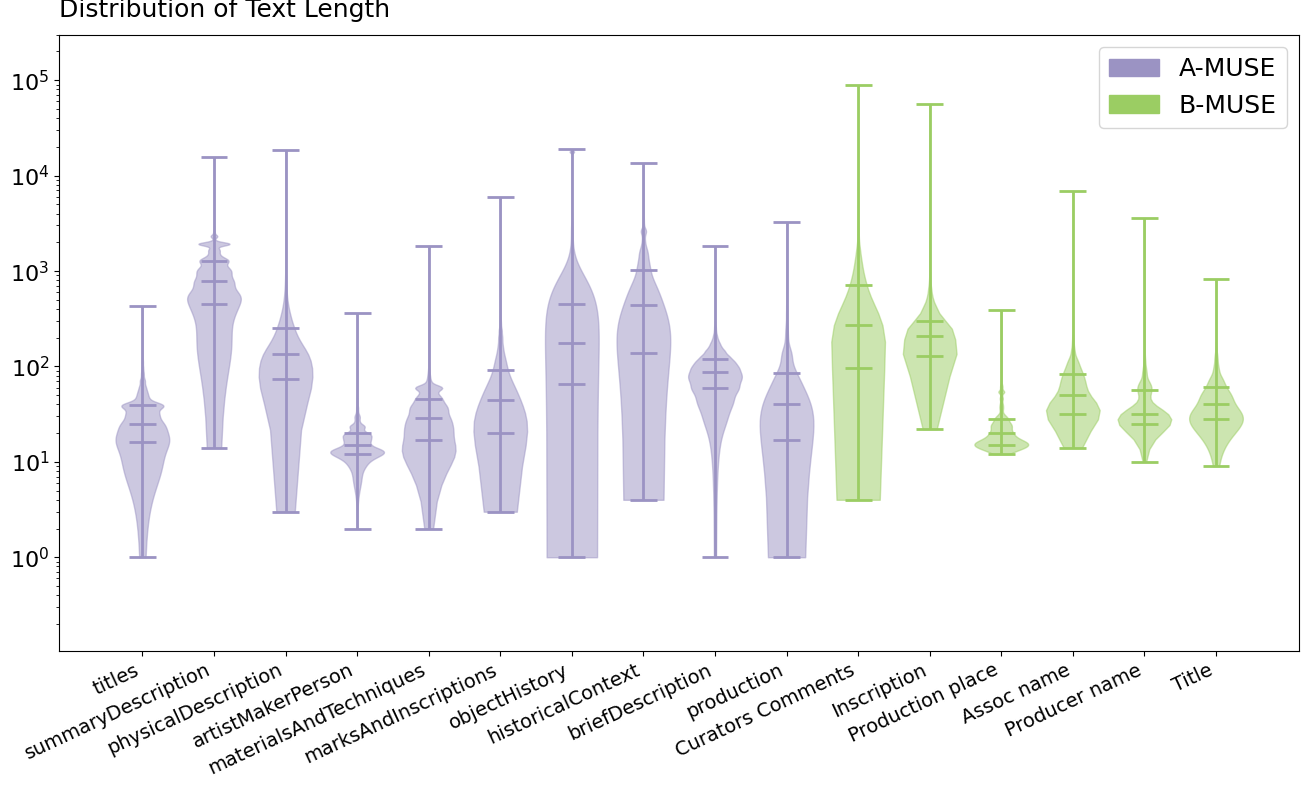

In [271]:
fig,ax = plt.subplots(figsize=(16,8))
x = np.arange(len(predict_keys_v)) + 1
violin_parts_v = ax.violinplot([attr_lengths_v[k] for k in predict_keys_v],positions=x,points=1000,quantiles=[[0.25,0.5,0.75]]*len(predict_keys_v),showextrema=True,widths=0.75)
x = np.arange(len(predict_keys_b)) + len(predict_keys_v) + 1
violin_parts_b = ax.violinplot([attr_lengths_b[k] for k in predict_keys_b],positions=x,points=1000,quantiles=[[0.25,0.5,0.75]]*len(predict_keys_b),showextrema=True,widths=0.75)
plt.xticks(np.arange(len(predict_keys_v) + len(predict_keys_b))+1,predict_keys_v + predict_keys_b,rotation=25,fontsize=14,ha='right')
plt.yticks(fontsize=16)
# plt.yticks([10000,20000],['10k','20k'],fontsize=16)
ax.set_ylabel(f"Distribution of Text Length", fontsize=18, ha="left", rotation=0)
ax.yaxis.set_label_coords(0.0, 1.02)
# color='#ABED73' color='#9B93C3'
col_brit = '#9BCD63'
brit_patch = mpatches.Patch(color=col_brit)
col_vamus = '#9B93C3'
vamus_patch = mpatches.Patch(color=col_vamus)
for partname in ('cbars','cmins','cmaxes','cquantiles'):
    vp = violin_parts_b[partname]
    vp.set_edgecolor(col_brit)
    vp.set_linewidth(2)

for vp in violin_parts_b['bodies']:
    vp.set_facecolor(col_brit)
    vp.set_edgecolor(col_brit)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)

for partname in ('cbars','cmins','cmaxes','cquantiles'):
    vp = violin_parts_v[partname]
    vp.set_edgecolor(col_vamus)
    vp.set_linewidth(2)

for vp in violin_parts_v['bodies']:
    vp.set_facecolor(col_vamus)
    vp.set_edgecolor(col_vamus)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
fake_handles = [vamus_patch,brit_patch]
labels = ['A-MUSE','B-MUSE']
ax.legend(fake_handles, labels,fontsize=18)
plt.yscale('log')
plt.ylim(1.05e-1,3e5)
figname = 'figs/text_distribution'
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.2)

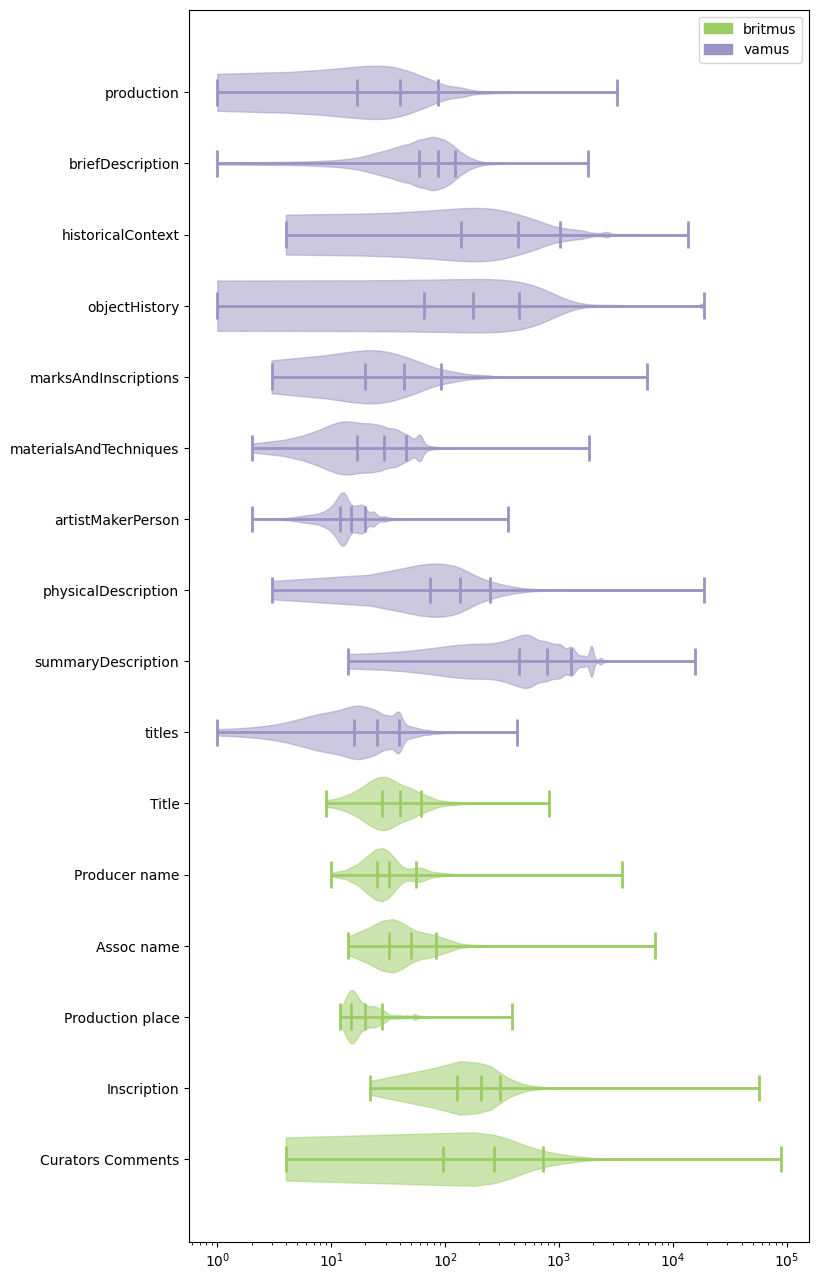

In [165]:
fig,ax = plt.subplots(figsize=(8,16))
x = np.arange(len(predict_keys_b)) + 1
violin_parts_b = ax.violinplot([attr_lengths_b[k] for k in predict_keys_b],positions=x,points=1000,quantiles=[[0.25,0.5,0.75]]*len(predict_keys_b),showextrema=True,widths=0.75,vert=False)
x = np.arange(len(predict_keys_v)) + len(predict_keys_b) + 1
violin_parts_v = ax.violinplot([attr_lengths_v[k] for k in predict_keys_v],positions=x,points=1000,quantiles=[[0.25,0.5,0.75]]*len(predict_keys_v),showextrema=True,widths=0.75,vert=False)
plt.yticks(np.arange(len(predict_keys_b) + len(predict_keys_v))+1,predict_keys_b + predict_keys_v,rotation=0)

# color='#ABED73' color='#9B93C3'
col_brit = '#9BCD63'
brit_patch = mpatches.Patch(color=col_brit)
col_vamus = '#9B93C3'
vamus_patch = mpatches.Patch(color=col_vamus)
for partname in ('cbars','cmins','cmaxes','cquantiles'):
    vp = violin_parts_b[partname]
    vp.set_edgecolor(col_brit)
    vp.set_linewidth(2)

for vp in violin_parts_b['bodies']:
    vp.set_facecolor(col_brit)
    vp.set_edgecolor(col_brit)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)

for partname in ('cbars','cmins','cmaxes','cquantiles'):
    vp = violin_parts_v[partname]
    vp.set_edgecolor(col_vamus)
    vp.set_linewidth(2)

for vp in violin_parts_v['bodies']:
    vp.set_facecolor(col_vamus)
    vp.set_edgecolor(col_vamus)
    vp.set_linewidth(1)
    vp.set_alpha(0.5)
fake_handles = [brit_patch,vamus_patch]
labels = ['britmus','vamus']
ax.legend(fake_handles, labels)
plt.xscale('log')

In [141]:
violin_parts['cbars']

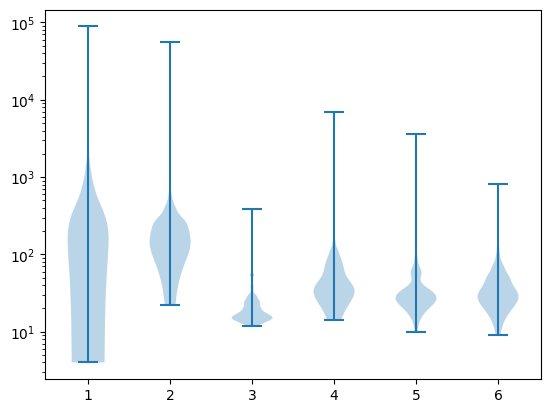

In [101]:
plt.violinplot([attr_lengths[k] for k in predict_keys],points=10000)
plt.yscale('log')

### Combination

In [21]:
class_info_b:pd.DataFrame = all_class_info['britmus']
class_info_v:pd.DataFrame = all_class_info['vamus']
thr_b = 5000
thr_v = 10000

In [22]:
class_info_classif_b = class_info_b[class_info_b['different_values'] < thr_b].sort_values('different_values',ascending=True)
class_info_classif_v = class_info_v[class_info_v['different_values'] < thr_v].sort_values('different_values',ascending=True)

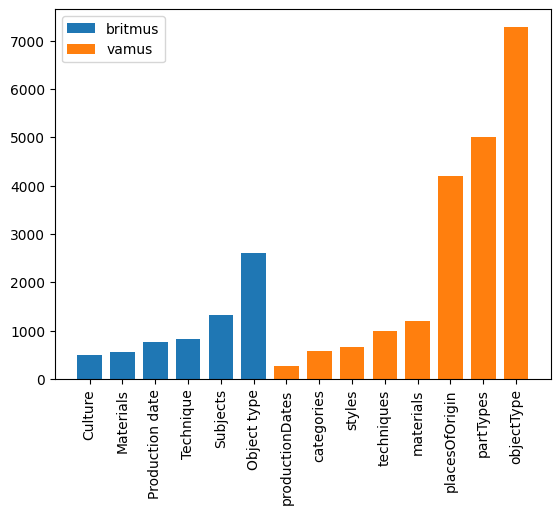

In [23]:
all_names = class_info_classif_b['attribute'].to_list() + class_info_classif_v['attribute'].to_list()
fig, ax = plt.subplots()

offset = 0
x = np.arange(len(class_info_classif_b['attribute']))
y = class_info_classif_b['different_values']

ax.bar(x+offset,y,0.75,label='britmus')

offset = x.max() + 1
x = np.arange(len(class_info_classif_v['attribute']))
y = class_info_classif_v['different_values']

ax.bar(x+offset,y,0.75,label='vamus')
ax.set_xticks(np.arange(len(all_names)),all_names,rotation=90)
ax.legend()

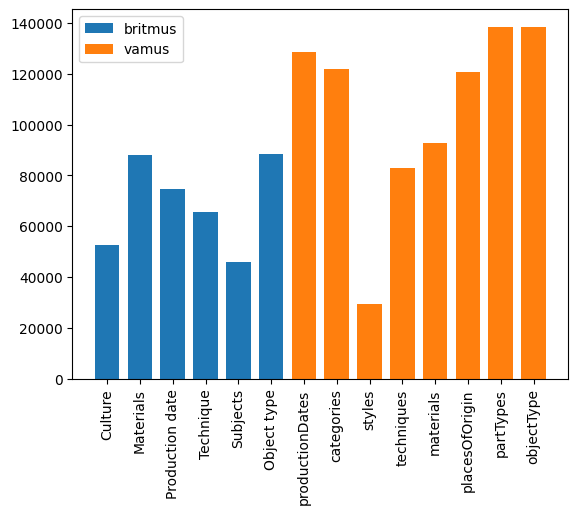

In [24]:
all_names = class_info_classif_b['attribute'].to_list() + class_info_classif_v['attribute'].to_list()
fig, ax = plt.subplots()

offset = 0
x = np.arange(len(class_info_classif_b['attribute']))
y = class_info_classif_b['num_known']

ax.bar(x+offset,y,0.75,label='britmus')

offset = x.max() + 1
x = np.arange(len(class_info_classif_v['attribute']))
y = class_info_classif_v['num_known']

ax.bar(x+offset,y,0.75,label='vamus')
ax.set_xticks(np.arange(len(all_names)),all_names,rotation=90)
ax.legend()

In [25]:
class_info_predict_b = class_info_b[class_info_b['different_values'] > thr_b].sort_values('med_known_len',ascending=True)
class_info_predict_v = class_info_v[class_info_v['different_values'] > thr_v].sort_values('med_known_len',ascending=True)

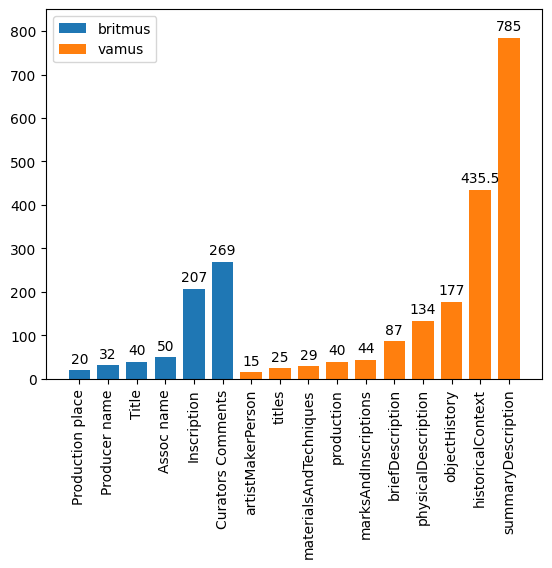

In [26]:
all_names = class_info_predict_b['attribute'].to_list() + class_info_predict_v['attribute'].to_list()
fig, ax = plt.subplots()

offset = 0
x = np.arange(len(class_info_predict_b['attribute']))
y = class_info_predict_b['med_known_len']

rects = ax.bar(x+offset,y,0.75,label='britmus')
ax.bar_label(rects, padding=3)

offset = x.max() + 1
x = np.arange(len(class_info_predict_v['attribute']))
y = class_info_predict_v['med_known_len']

rects = ax.bar(x+offset,y,0.75,label='vamus')
ax.bar_label(rects, padding=3)
ax.set_xticks(np.arange(len(all_names)),all_names,rotation=90)
ax.set_ylim(0, 850)
ax.legend()

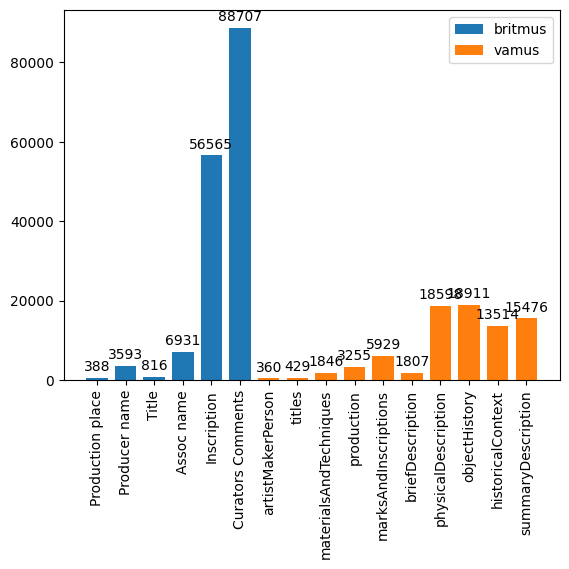

In [27]:
all_names = class_info_predict_b['attribute'].to_list() + class_info_predict_v['attribute'].to_list()
fig, ax = plt.subplots()

offset = 0
x = np.arange(len(class_info_predict_b['attribute']))
y = class_info_predict_b['max_known_len']

rects = ax.bar(x+offset,y,0.75,label='britmus')
ax.bar_label(rects, padding=3)

offset = x.max() + 1
x = np.arange(len(class_info_predict_v['attribute']))
y = class_info_predict_v['max_known_len']

rects = ax.bar(x+offset,y,0.75,label='vamus')
ax.bar_label(rects, padding=3)
ax.set_xticks(np.arange(len(all_names)),all_names,rotation=90)
# ax.set_ylim(0, 850)
ax.legend()

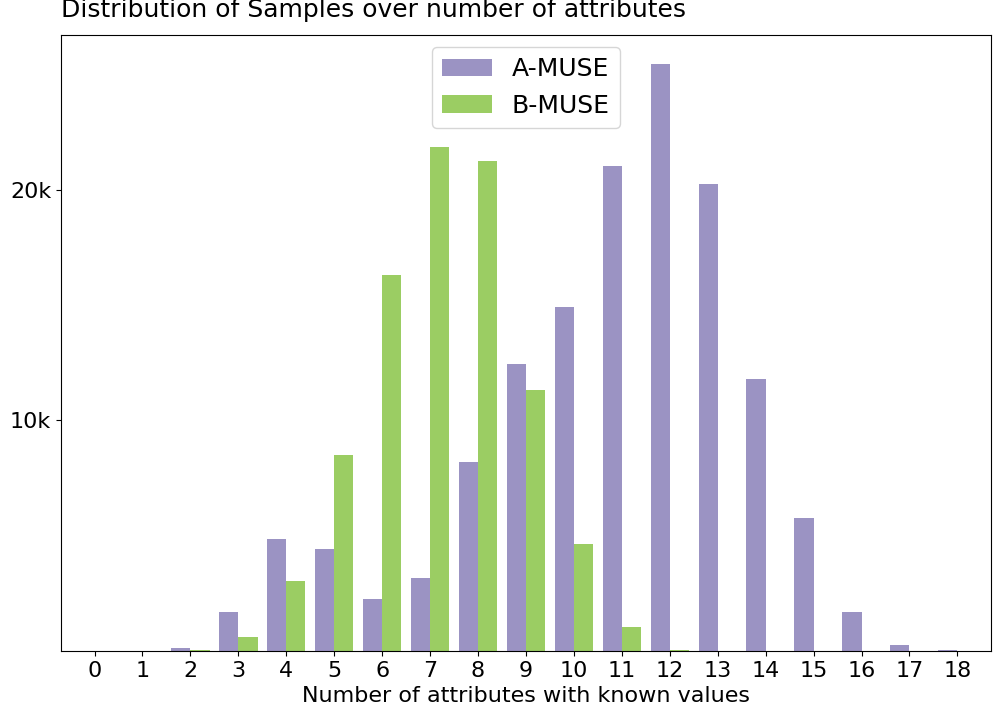

In [275]:
vamus_unk = [27, 249, 1669, 5739, 11808, 20236, 25462, 21039, 14911, 12453, 8190, 3164, 2264, 4431, 4851, 1698, 129, 0, 0][::-1]
britmus_unk = [17, 1010, 4631, 11319, 21248, 21862, 16318, 8494, 3035, 601, 46, 0, 0][::-1]

fig, ax = plt.subplots(figsize=(12,8))
width=0.4

y = vamus_unk
x = np.arange(len(y))
# color='#ABED73' color='#9B93C3'
offset = -width/2
# rects = ax.bar(x+offset,y,width,label='B-MUSE',color='#ABED73')
rects = ax.bar(x+offset,y,width,label='A-MUSE',color='#9B93C3')
# ax.bar_label(rects, padding=3)
ax.set_ylabel(f"Distribution of Samples over number of attributes", fontsize=18, ha="left", rotation=0)
ax.yaxis.set_label_coords(0.0, 1.02)

y = britmus_unk
x = np.arange(len(y))
offset = width/2

rects = ax.bar(x+offset,y,width,label='B-MUSE',color='#9BCD63')
# rects = ax.bar(x+offset,y,width,label='vamus',color='#9BA3C3')
# rects = ax.bar(x+offset,y,width,label='vamus',color='#ABA3C3')
# ax.bar_label(rects, padding=3)
ax.set_xticks(np.arange(len(vamus_unk)))
plt.xticks(fontsize=16)
plt.yticks([10000,20000],['10k','20k'],fontsize=16)
# ax.set_ylim(0, 850)
ax.set_xlim(-0.7,18.7)
ax.set_xlabel('Number of attributes with known values',fontsize=16)
ax.legend(loc='upper center',fontsize=18)
plt.savefig('figs/num_known.pdf',bbox_inches='tight', pad_inches=0.2)

### Var Context

In [3]:
var_data = np.genfromtxt("var_context_data.csv", dtype=float, delimiter=',', names=True) 
var_data


array([( 0.,  2.29, 37.6 , 11.96, 15.84, 34.46),
       ( 1., 18.14, 40.77, 11.96, 15.84, 34.46),
       ( 2., 29.06, 43.33, 11.96, 15.84, 34.46),
       ( 3., 35.93, 45.43, 11.96, 15.84, 34.46),
       ( 4., 40.65, 47.23, 11.96, 15.84, 34.46),
       ( 5., 43.75, 48.32, 11.96, 15.84, 34.46),
       ( 6., 45.94, 49.68, 11.96, 15.84, 34.46),
       ( 7., 47.77, 50.59, 11.96, 15.84, 34.46),
       ( 8., 49.24, 51.28, 11.96, 15.84, 34.46),
       ( 9., 50.26, 52.07, 11.96, 15.84, 34.46),
       (10., 50.67, 52.34, 11.96, 15.84, 34.46),
       (11., 51.44, 52.85, 11.96, 15.84, 34.46),
       (12., 51.9 , 53.41, 11.96, 15.84, 34.46),
       (13., 52.53, 53.81, 11.96, 15.84, 34.46),
       (14., 52.72, 54.03, 11.96, 15.84, 34.46),
       (15., 53.15, 54.26, 11.96, 15.84, 34.46),
       (16., 53.38, 54.69, 11.96, 15.84, 34.46),
       (17., 53.64, 54.81, 11.96, 15.84, 34.46)],
      dtype=[('Context_Length', '<f8'), ('MUSE_no_img', '<f8'), ('MUSE_img', '<f8'), ('CLIP_orig', '<f8'), ('CLIP_FT_

In [4]:
var_data = np.array([list(vd) for vd in var_data])
var_data

array([[ 0.  ,  2.29, 37.6 , 11.96, 15.84, 34.46],
       [ 1.  , 18.14, 40.77, 11.96, 15.84, 34.46],
       [ 2.  , 29.06, 43.33, 11.96, 15.84, 34.46],
       [ 3.  , 35.93, 45.43, 11.96, 15.84, 34.46],
       [ 4.  , 40.65, 47.23, 11.96, 15.84, 34.46],
       [ 5.  , 43.75, 48.32, 11.96, 15.84, 34.46],
       [ 6.  , 45.94, 49.68, 11.96, 15.84, 34.46],
       [ 7.  , 47.77, 50.59, 11.96, 15.84, 34.46],
       [ 8.  , 49.24, 51.28, 11.96, 15.84, 34.46],
       [ 9.  , 50.26, 52.07, 11.96, 15.84, 34.46],
       [10.  , 50.67, 52.34, 11.96, 15.84, 34.46],
       [11.  , 51.44, 52.85, 11.96, 15.84, 34.46],
       [12.  , 51.9 , 53.41, 11.96, 15.84, 34.46],
       [13.  , 52.53, 53.81, 11.96, 15.84, 34.46],
       [14.  , 52.72, 54.03, 11.96, 15.84, 34.46],
       [15.  , 53.15, 54.26, 11.96, 15.84, 34.46],
       [16.  , 53.38, 54.69, 11.96, 15.84, 34.46],
       [17.  , 53.64, 54.81, 11.96, 15.84, 34.46]])

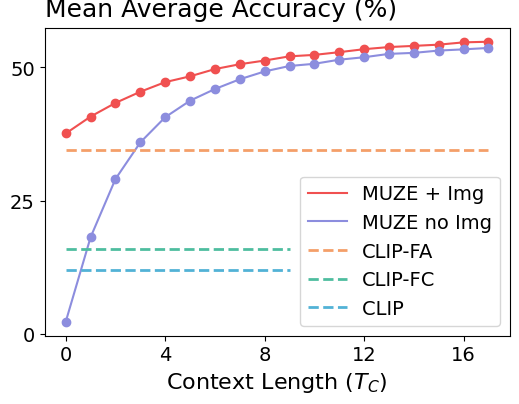

In [5]:
ctx_len = var_data[:,0]
colors = [f'C{i}' for i in range(10)]
#f49f69
colors = ["#8c8dde","#f05050","#52b2d6","#4ebd9f","#f49f69"]
fig,ax = plt.subplots(figsize=(6,4))
plt.plot(ctx_len,var_data[:,2],label='MUZE + Img',c=colors[1])
plt.scatter(ctx_len,var_data[:,2],c=colors[1])
plt.plot(ctx_len,var_data[:,1],label='MUZE no Img',c=colors[0])
plt.scatter(ctx_len,var_data[:,1],c=colors[0])
plt.plot(ctx_len,var_data[:,5],label='CLIP-FA',c=colors[4],linestyle='--',linewidth=2)
plt.plot(ctx_len[:10],var_data[:10,4],label='CLIP-FC',c=colors[3],linestyle='--',linewidth=2)
plt.plot(ctx_len[:10],var_data[:10,3],label='CLIP ',c=colors[2],linestyle='--',linewidth=2)
plt.xticks([0,4,8,12,16],fontsize=14)
plt.yticks([0,25,50],fontsize=14)
plt.xlabel("Context Length ($T_C$)",fontsize=16)
plt.ylabel("Mean Average Accuracy (%)",fontsize=18, ha="left", rotation=0)
ax.yaxis.set_label_coords(0.0, 1.02)
plt.legend(fontsize=14)
plt.savefig('figs/var_context_muze.pdf',bbox_inches='tight', pad_inches=0.15)

### model

In [ ]:
key = 'materials'
dataset = 'vamus'
arch = '2'

args = f"""
    --supreme-key {key} \
    --include-context \
    --exp-name {dataset}_{key}_T \
    --group {dataset}_T{arch}_28feb \
    --head-architecture {arch} \
    --lora-rank 32 \
    --lora-alpha 1.0 \
    --lora-dropout 0.0 \
    --save-frequency 2 \
    --report-to wandb \
    --wandb_project_name museum-tabdata-test\
    --dataset-type csv \
    --train-data /home/username/open_clip/finetuning/dataset_splits/{dataset}_train.csv \
    --val-data /home/username/open_clip/finetuning/dataset_splits/{dataset}_val_hala.csv \
    --test-data /home/username/open_clip/finetuning/dataset_splits/{dataset}_test.csv \
    --csv-img-key image_path \
    --csv-caption-key caption \
    --accum-freq 1 \
    --csv-separator , \
    --model ViT-B-32 \
    --pretrained laion2b_s34b_b79k \
    --seed 0 \
    --local-loss \
    --gather-with-grad \
    --warmup 0 \
    --batch-size 1024 \
    --lr 1e-4 \
    --epochs 101 \
    --workers 8 \
    --coca-contrastive-loss-weight 0 \
    --coca-caption-loss-weight 1 \
    --dataset-resampled \
    --lock-text \
    --lock-text-unlocked-layers 13 \
    --lock-image \
    --lock-image-unlocked-groups 5 \
    --precision fp16 \
    --classes /home/username/open_clip/finetuning/dataset_splits/{dataset}_classes.json \
""".replace('\\',"").split()
args = parse_args(args)
init_distributed_device(args)
args

In [30]:

model_kwargs = {}
device = "cpu"

model, preprocess_train, preprocess_val = create_model_and_transforms(
        args.model,
        args.pretrained,
        precision=args.precision,
        device=device,
        jit=args.torchscript,
        force_quick_gelu=args.force_quick_gelu,
        force_custom_text=args.force_custom_text,
        force_patch_dropout=args.force_patch_dropout,
        force_image_size=args.force_image_size,
        image_mean=args.image_mean,
        image_std=args.image_std,
        image_interpolation=args.image_interpolation,
        image_resize_mode=args.image_resize_mode,  # only effective for inference
        aug_cfg=args.aug_cfg,
        pretrained_image=args.pretrained_image,
        output_dict=True,
        **model_kwargs,
    )

tokenizer = get_tokenizer(args.model)
data = get_data_transformer(
    args,
    (preprocess_train, preprocess_val),
    epoch=0,
    tokenizer=tokenizer,
    return_paths=True ##TODO ar trebui args.return_paths
)

In [31]:
maxx_metric=0
arhitecture=args.head_architecture
head,loss=create_head_transformer(arhitecture)
head=head.to(device)


In [32]:
head_path = "/home/username/open_clip/saved_models/vamus_keys/materials/2_transformer_head/2_0.07008.pt"

In [33]:
def translate_state_dict(sd):
    return {k.replace('module.',''):v for k,v in sd.items()}

In [34]:
import torch.distributed as dist
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '11235'
dist.init_process_group(backend='gloo')

In [35]:
head_sd = torch.load(head_path,map_location=torch.device(device))

In [36]:
head.load_state_dict(translate_state_dict(head_sd))

<All keys matched successfully>

In [37]:

f = f"/home/username/open_clip/finetuning/dataset_splits/{dataset}_all_CLIP_embeddings.pt"
# print("f file",f)
if os.path.exists(f):
    all_emb=torch.load(f,map_location=device)


In [38]:
image_emb,text_emb=all_emb["images"],all_emb["texts"]        
classnames = data["classes"] if "classes" in data else None


In [39]:
val_dataloader = data["val_muse"][key].dataloader
len(val_dataloader)
train_dataloader = data["train_muse"][0].dataloader
len(train_dataloader)

105

### Data analysis

In [40]:
classnames = data['classes']

In [41]:
import pandas as pd

In [42]:
at_names = []
num_classes = []
avg_len = []
for k,v in classnames.items():
    at_names.append(k)
    num_classes.append(len(v))
    avg_len.append(sum([len(tx) for tx in v.values()])/len(v))
    # print(k,len(v),sum([len(tx) for tx in v.values()])/len(v))

class_info = pd.DataFrame({
    "attribute":at_names,
    "different_values":num_classes,
    "avg_len_of_values":avg_len
})
class_info.sort_values('different_values',ascending=True)


,attribute,different_values,avg_len_of_values
12,productionDates,266,10.661654
8,categories,573,7.506108
9,styles,655,7.087023
6,techniques,999,8.260260
5,materials,1199,7.065888
11,placesOfOrigin,4198,9.729395
10,partTypes,5006,6.938873
0,objectType,7281,13.126631
4,artistMakerPerson,16758,9.909118
17,production,18930,53.607554


In [43]:
num_values = {k:0 for k in classnames}
num_unknowns = {k:0 for k in classnames}
num_single = {k:0 for k in classnames}
num_uniques = {k:set() for k in classnames}
total_num = 0
for batch in val_dataloader:
    images, texts,paths, attributes, querries, labels = batch
    attributes=[json.loads(a) for a in attributes]
    print(len(attributes))
    for att in attributes:
        for k in att:
            # print('',k,att[k])
            if len(att[k]) == 0 or att[k][0] == 'unknown' or att[k][0] == ';':
                num_unknowns[k] += 1
            if len(att[k]) == 1:
                num_single[k] += 1
            num_values[k] += len(att[k])
            num_uniques[k].update(att[k])
        total_num += 1

print(total_num)
print(num_unknowns)    
print(num_values)    

# class_info['num_unknown'] = [num_unknowns[k] for k in class_info['attribute']]
# class_info['num_single'] = [num_single[k] for k in class_info['attribute']]
# class_info['num_uniques_in_val'] = [len(num_uniques[k]) for k in class_info['attribute']]
# class_info['num_avg_values'] = [num_values[k] / total_num for k in class_info['attribute']]
# class_info.sort_values('num_unknown',ascending=False)

1024
1024
1024
1024
1024
1024
1024
1024
1024
784
10000
{'objectType': 2, 'titles': 6104, 'summaryDescription': 7049, 'physicalDescription': 1637, 'artistMakerPerson': 5970, 'materials': 3346, 'techniques': 3994, 'materialsAndTechniques': 1448, 'categories': 1129, 'styles': 7782, 'partTypes': 0, 'placesOfOrigin': 1203, 'productionDates': 723, 'marksAndInscriptions': 7297, 'objectHistory': 5932, 'historicalContext': 9454, 'briefDescription': 118, 'production': 8557}
{'objectType': 10015, 'titles': 11457, 'summaryDescription': 32123, 'physicalDescription': 27536, 'artistMakerPerson': 13911, 'materials': 18400, 'techniques': 14871, 'materialsAndTechniques': 13427, 'categories': 30016, 'styles': 11468, 'partTypes': 14994, 'placesOfOrigin': 10659, 'productionDates': 10107, 'marksAndInscriptions': 11273, 'objectHistory': 76875, 'historicalContext': 14439, 'briefDescription': 39193, 'production': 11216}


In [44]:
'wood' in num_uniques['materials']

True

In [45]:
class_info['num_unknown'] = [num_unknowns[k] for k in class_info['attribute']]
class_info['num_single'] = [num_single[k] for k in class_info['attribute']]
class_info['num_uniques_in_val'] = [len(num_uniques[k]) for k in class_info['attribute']]
class_info['num_avg_values'] = [num_values[k] / total_num for k in class_info['attribute']]
class_info.sort_values('num_unknown',ascending=False)

,attribute,different_values,avg_len_of_values,num_unknown,num_single,num_uniques_in_val,num_avg_values
15,historicalContext,28887,98.962786,9454,9526,3555,1.4439
17,production,18930,53.607554,8557,9535,1946,1.1216
9,styles,655,7.087023,7782,8988,305,1.1468
13,marksAndInscriptions,41916,56.057615,7297,9429,3546,1.1273
2,summaryDescription,128006,117.104229,7049,7179,13747,3.2123
1,titles,40441,23.405306,6104,9076,3913,1.1457
4,artistMakerPerson,16758,9.909118,5970,7001,3325,1.3911
14,objectHistory,78656,87.208910,5932,7343,9819,7.6875
6,techniques,999,8.260260,3994,6725,477,1.4871
5,materials,1199,7.065888,3346,5499,523,1.8400


In [46]:
batch = next(iter(data["val_muse"][key].dataloader))

In [47]:
images, texts,paths, attributes, querries, labels = batch
attributes=[json.loads(a) for a in attributes]


In [ ]:
paths[:10]

In [49]:
labels[0].argmax()

tensor(361)

In [50]:
attributes[0]['materials']

['fritware']

In [51]:
labels[0].argmax().flatten().tolist()

[361]

In [52]:
classnames[querries[0]][str(labels[0].argmax().flatten().tolist()[0]+1)]

'fritware'

In [53]:
args.include_context = True

In [54]:
def create_classifier(key):
    emb_list = []
    for idx, cln in classnames[key].items():
        emb_list.append((idx, text_emb[cln]))
        # emb_list.append((idx, text_emb[cln] / text_emb[cln].norm(2)))
    emb_list.sort(key=lambda x: int(x[0]))
    idx_list, emb_list = zip(*emb_list)
    classifier = torch.stack(emb_list)
    return idx_list, classifier        

In [55]:
idx_list, classifier = create_classifier('materials')

In [56]:
idx_list[:10]

('1', '2', '3', '4', '5', '6', '7', '8', '9', '10')

In [57]:
batch_inputs=[]
batch_targets=[]
for i in range(len(paths)):
    model_inputs=[image_emb[paths[i].replace('scratch','work')]]
    if args.include_context:
        for k,v in attributes[i].items():
            if k==querries[i]:
                continue
            model_inputs.append(text_emb[k])
                # target=text_emb[v]
            if len(v)>0: curr_text=sum([text_emb[vv] for vv in v])
            else: curr_text=text_emb["unknown"]
            model_inputs.append(curr_text)
            # model_inputs.append(text_emb[v])
    k = querries[i]
    v = attributes[i][k]
    model_inputs.append(text_emb[k])
    model_inputs.append(text_emb["[MASK]"])
    
    batch_inputs.append(torch.stack(model_inputs))
    if len(v)>0: target=sum([text_emb[vv] for vv in v])
    else: target=text_emb["unknown"]
    batch_targets.append(target / target.norm(2))
batch_inputs=torch.stack(batch_inputs).to(device)
batch_targets=torch.stack(batch_targets).to(device)

target = labels.to(device)

model_out = head(batch_inputs)
# model_out /= model_out.norm(2,dim=0)
print(model_out.shape)
logits = 100. * model_out @ classifier.T.float()
logits_true = 100. * batch_targets.float() @ classifier.T.float()
true = target.cpu()
pred = logits.float().cpu()
pred_target = logits_true.float().cpu()


torch.Size([1024, 512])


In [58]:
images[0]

tensor([[[1.7114, 1.7114, 1.7114,  ..., 1.8427, 1.8427, 1.8427],
         [1.7114, 1.7114, 1.7114,  ..., 1.8427, 1.8427, 1.8281],
         [1.7114, 1.7114, 1.7114,  ..., 1.8427, 1.8427, 1.7990],
         ...,
         [1.6822, 1.6676, 1.6530,  ..., 1.8427, 1.8427, 1.8427],
         [1.6822, 1.6822, 1.6676,  ..., 1.8427, 1.8427, 1.8135],
         [1.6968, 1.6822, 1.6822,  ..., 1.8427, 1.8427, 1.7990]],

        [[1.8498, 1.8498, 1.8498,  ..., 1.9848, 1.9848, 1.9848],
         [1.8498, 1.8498, 1.8498,  ..., 1.9848, 1.9848, 1.9698],
         [1.8498, 1.8498, 1.8498,  ..., 1.9848, 1.9848, 1.9398],
         ...,
         [1.8348, 1.8198, 1.8047,  ..., 1.9848, 1.9848, 1.9848],
         [1.8348, 1.8348, 1.8198,  ..., 1.9848, 1.9848, 1.9548],
         [1.8498, 1.8348, 1.8348,  ..., 1.9848, 1.9848, 1.9398]],

        [[1.9326, 1.9326, 1.9326,  ..., 2.0606, 2.0606, 2.0606],
         [1.9326, 1.9326, 1.9326,  ..., 2.0606, 2.0606, 2.0464],
         [1.9326, 1.9326, 1.9326,  ..., 2.0606, 2.0606, 2.

In [ ]:
autocast = torch.cuda.amp.autocast
with torch.no_grad(), autocast():
    image_features = model.encode_image(images.to(device))
    image_features = F.normalize(image_features, dim=-1)
    logits_clip = 100. * image_features @ classifier.T

pred_clip = logits_clip.float().cpu()

In [ ]:
vals, indices = pred.topk(5,dim=1)

In [ ]:
true.shape

torch.Size([1024, 1199])

In [ ]:
pred_target[:10,:10]

tensor([[357.1783, 418.7553, 319.4635, 334.7738, 421.9572, 382.3274, 389.2531,
         186.5497, 420.6488, 378.9780],
        [679.3333, 970.5450, 855.7855, 665.8636, 841.5512, 781.5766, 760.0106,
         376.3854, 861.3144, 676.3293],
        [543.2809, 765.5826, 584.8934, 528.2739, 877.9656, 614.4617, 862.2552,
         317.9633, 873.9933, 789.1888],
        [674.4360, 946.9751, 812.2408, 770.3830, 928.5428, 788.8851, 815.7776,
         380.5206, 898.9797, 715.9536],
        [625.4238, 755.0360, 618.5350, 595.4689, 724.9350, 656.9584, 682.9440,
         391.2966, 771.3665, 644.5720],
        [524.5215, 714.3314, 626.7251, 906.0864, 692.9880, 634.9200, 613.7817,
         297.7865, 704.4275, 526.5735],
        [586.1972, 700.8953, 589.3159, 570.3748, 671.6599, 626.0552, 633.3635,
         358.8451, 732.3685, 570.5939],
        [543.2809, 765.5826, 584.8934, 528.2739, 877.9656, 614.4617, 862.2552,
         317.9633, 873.9933, 789.1888],
        [692.6625, 941.5329, 742.9333, 750.1595,

In [ ]:
true[:10,:10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
for i in range(10):
    print(i+1,classnames['materials'][str(i+1)])

1 cloth
2 paper
3 pencil
4 watercolour
5 ink
6 printing
7 wash
8 millboard
9 photographic
10 bronze


In [ ]:
indices[:10]

tensor([[ 361,  469,  321,  379,   11],
        [   1, 1084,    2,  153,   11],
        [  17,  276, 1194,   45,  771],
        [   1,   11,    4,  264,   45],
        [ 321,  379,  396,  264,   11],
        [ 262,    3,   92, 1074,   11],
        [ 145,  321,  378,  379,    8],
        [ 276,   45, 1194,  264,  771],
        [  11,    1,  264, 1084,    8],
        [ 264,   11, 1084,   45,  379]])

In [ ]:
indices[:10]

tensor([[ 361,  469,  321,  379,   11],
        [   1, 1084,    2,  153,   11],
        [  17,  276, 1194,   45,  771],
        [   1,   11,    4,  264,   45],
        [ 321,  379,  396,  264,   11],
        [ 262,    3,   92, 1074,   11],
        [ 145,  321,  378,  379,    8],
        [ 276,   45, 1194,  264,  771],
        [  11,    1,  264, 1084,    8],
        [ 264,   11, 1084,   45,  379]])

In [ ]:
predicted_classes = []
for i in range(100):
    curr_classes = []
    for idx in indices[i,:]:
        curr_classes.append(classnames[querries[i]][str(idx.item()+1)])
    predicted_classes.append(curr_classes)

In [ ]:
target_classes = []
for i in range(100):
    target_classes.append(attributes[i]['materials'])

In [ ]:
print(classifier.shape)

torch.Size([1199, 512])


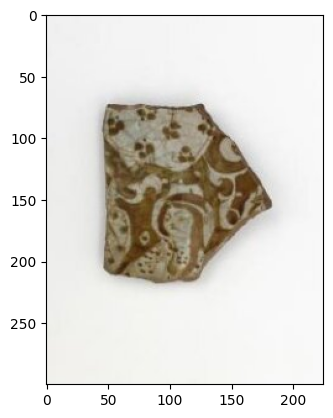

In [ ]:
img = Image.open(paths[0])
plt.imshow(img)
plt.show()

In [ ]:
start_idx = 0

indexes = [start_idx + i for i in range(9)]
# Generate some sample images (replace this with your own image data)
images = [Image.open(paths[i]) for i in indexes]

# Sample captions (replace these with your own captions)
captions = [f'Q: {querries[i]}? A: {classnames[querries[i]][str(labels[i].argmax().flatten().tolist()[0]+1)]}' for i in indexes]

captions

['Q: materials? A: fritware',
 'Q: materials? A: paper',
 'Q: materials? A: unknown',
 'Q: materials? A: paper',
 'Q: materials? A: stoneware',
 'Q: materials? A: watercolour',
 'Q: materials? A: earthenware',
 'Q: materials? A: unknown',
 'Q: materials? A: paper']

In [ ]:
target_classes[:10]

[['fritware'],
 ['paper', 'pencil'],
 ['unknown'],
 ['paper', 'pencil', 'ink', 'watercolour'],
 ['celadon', 'stoneware'],
 ['watercolour'],
 ['earthenware'],
 ['unknown'],
 ['opaque', 'watercolour', 'paper', 'gold', 'paint'],
 ['nylon', 'satin']]

In [ ]:
predicted_classes[:10]

[['fritware', 'printed', 'stoneware', 'decoration', 'colour'],
 ['paper', 'audio', 'pencil', 'papier', 'colour'],
 ['unknown', 'print', 'digital', 'film', 'natural'],
 ['paper', 'colour', 'ink', 'skin', 'film'],
 ['stoneware', 'decoration', 'stone', 'skin', 'colour'],
 ['watercolor', 'watercolour', 'water-colour', 'watercolours', 'colour'],
 ['earthenware', 'stoneware', 'ceramics', 'decoration', 'photographic'],
 ['print', 'film', 'digital', 'skin', 'natural'],
 ['colour', 'paper', 'skin', 'audio', 'photographic'],
 ['skin', 'colour', 'audio', 'film', 'decoration']]

In [ ]:
def average_precision_per_class2(scores, targets:torch.Tensor, return_at_1=False):
    ap = torch.zeros(scores.size(1))
    ap1 = torch.zeros(scores.size(1))
    ap5 = torch.zeros(scores.size(1))
    ac5 = torch.zeros(scores.size(1))
    rg = torch.arange(1, scores.size(0) + 1).float()
    # compute average precision for each class
    batch_sz=2048
    for k in range((scores.size(1)-1)//batch_sz+1):
        # sort scores
        scores_k = scores[:, k*batch_sz:(k+1)*batch_sz]
        targets_k = targets[:, k*batch_sz:(k+1)*batch_sz]
        _, sortind = torch.sort(scores_k, 0, True)
        sortcol = torch.arange(0,sortind.shape[1]).repeat(sortind.shape[0],1)
        truth = targets_k[sortind,sortcol]
        tp = truth.float().cumsum(0)
        # compute precision curve
        precision = tp.div(rg.unsqueeze(1))
        # compute average precision
        ac5[k*batch_sz:(k+1)*batch_sz] = truth[:4,:].any(0).float()
        ap1[k*batch_sz:(k+1)*batch_sz] = precision[0,:]
        ap5[k*batch_sz:(k+1)*batch_sz] = precision[4,:]
        ap[k*batch_sz:(k+1)*batch_sz] = torch.where(truth.bool(),precision,torch.zeros_like(precision)).sum(0) / torch.clip((truth.sum(0)), min=1)
        # ap[k*batch_sz:(k+1)*batch_sz] = precision[truth.bool()].view_as(truth).sum(0) / torch.clip((truth.sum(0)), min=1)
    if return_at_1:
        return ap, ap1, ap5, ac5
    else:
        return ap


In [ ]:
scores = average_precision_per_class2(pred,true,True)
print([sc.mean().item() for sc in scores])
scores = average_precision_per_class2(pred.T,true.T,True)
print([sc.mean().item() for sc in scores])

[0.06278719007968903, 0.06505421549081802, 0.04386989027261734, 0.088407002389431]
[0.5917167663574219, 0.6416015625, 0.16757814586162567, 0.7138671875]


In [ ]:
scores = average_precision_per_class2(pred_clip,true,True)
print([sc.mean().item() for sc in scores])
scores = average_precision_per_class2(pred_clip.T,true.T,True)
print([sc.mean().item() for sc in scores])

[0.018020065501332283, 0.01751459576189518, 0.010842368938028812, 0.03169307857751846]
[0.10766717046499252, 0.03515625, 0.04257812350988388, 0.1669921875]


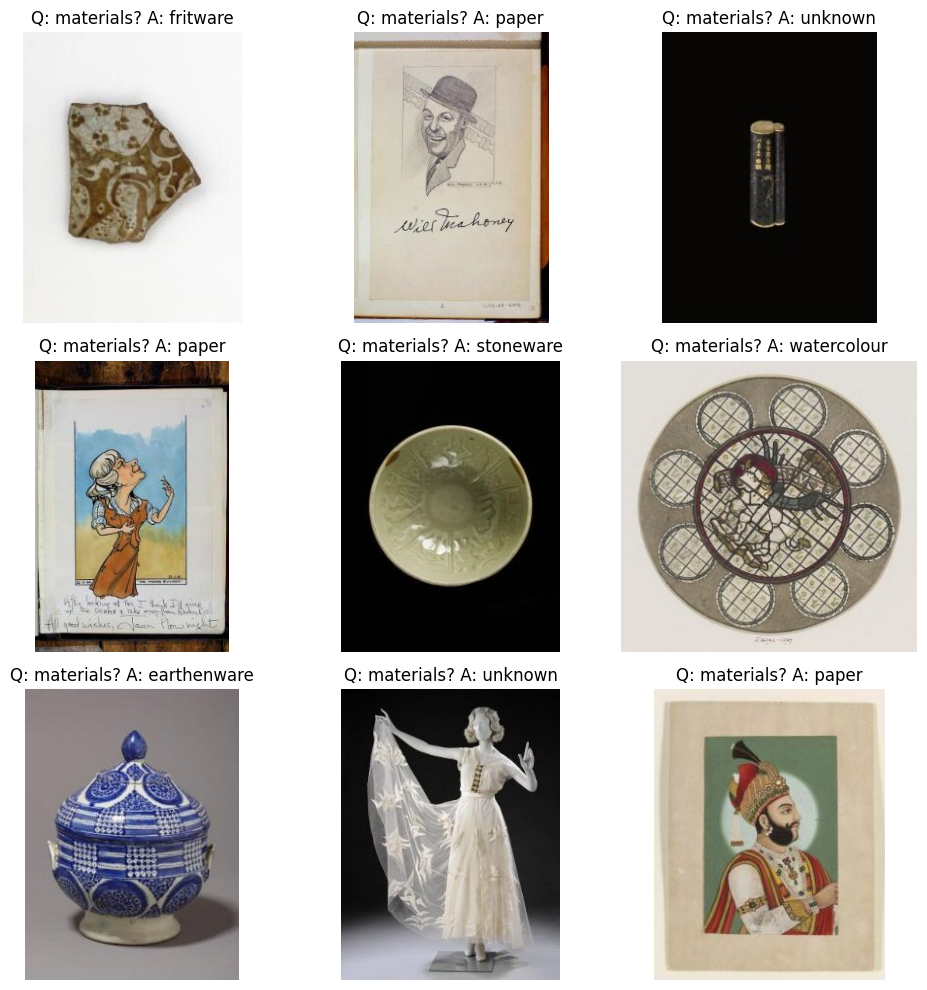

In [ ]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Plot each image with its caption
for ax, img, caption in zip(axes.flat, images, captions):
    ax.imshow(img)
    ax.set_title(caption)
    ax.axis('off')

plt.tight_layout()
plt.show()
